In [1]:
import sagemaker

from sagemaker.tensorflow import TensorFlow

model_dir = '/opt/ml/model'
train_instance_type = 'ml.p3.8xlarge'
# train_instance_type = 'local'
# hyperparameters = {'epochs': 1, 'batch_size': 32, 'learning_rate': 0.01, 'training': 's3://sagemaker-eu-west-1-291287855072/Data/training/btc_train.csv', 'validation': 's3://sagemaker-eu-west-1-291287855072/Data/validation/btc_val.csv'}
hyperparameters = {'epochs':35, 'batch_size': 32, 'learning_rate': 0.01}

estimator = TensorFlow(
                       source_dir='./',
                       entry_point='Transformer_run_on_AWS.py',
                       model_dir=model_dir,
                       instance_type=train_instance_type,
                       instance_count=1,
                       hyperparameters=hyperparameters,
                       role=sagemaker.get_execution_role(),
                       base_job_name='tf-sentiment',
                       framework_version='2.1',
                       py_version='py3',
                       script_mode=True)

In [ ]:
inputs = {'training': 's3://sagemaker-eu-west-1-291287855072/Data/training/', 'validation': 's3://sagemaker-eu-west-1-291287855072/Data/validation/'}
# if pass in the full data path like s3://******/Data/training/train.csv, pd.read_csv will give error 'pandas.errors.ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.'
estimator.fit(inputs)

In [3]:
import json 

!aws s3 cp {estimator.model_data} ./model/model.tar.gz
!tar -xzf ./model/model.tar.gz -C ./model

with open('./model/history.p', "r") as f:
    history = json.load(f)

download: s3://sagemaker-eu-west-1-291287855072/tf-sentiment-2021-11-03-20-57-17-102/output/model.tar.gz to model/model.tar.gz


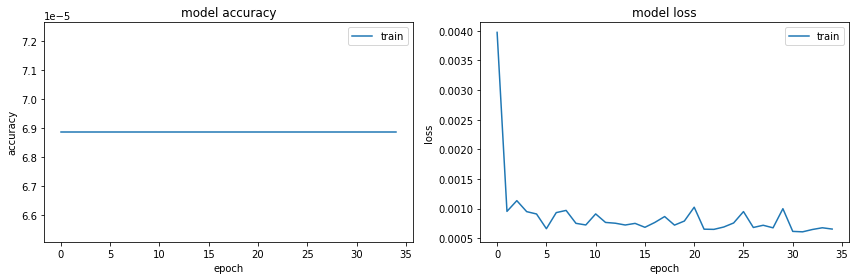

In [4]:

import matplotlib.pyplot as plt

def plot_training_curves(history): 
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    ax = axes[0]
    ax.plot(history['accuracy'], label='train')
    ax.set(title='model accuracy', ylabel='accuracy', xlabel='epoch')
    ax.legend()
    ax = axes[1]
    ax.plot(history['loss'], label='train')
    ax.set(title='model loss', ylabel='loss', xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(history)

In [5]:
# getting estimator training job name
training_job_name = estimator.latest_training_job.name
training_job_name

'tf-sentiment-2021-11-03-20-57-17-102'

In [10]:
import numpy as np
import pandas as pd

seq_len = 240
def get_test_data(test):
    test_data = pd.read_csv(test)
    test_data = test_data.values
    X_test, y_test = [], []
    for i in range(seq_len, len(test_data)):
        X_test.append(test_data[i-seq_len:i])
        y_test.append(test_data[:, 3][i])
    X_test, y_test = np.array(X_test), np.array(y_test)
    print('x test', X_test.shape,'y test', y_test.shape)
    return X_test, y_test


In [ ]:
# Getting test npy files 
X_test, y_test = get_test_data('s3://cmajorsolo-transformerbucket/data/btc_test.csv')

In [12]:
# saving X_test, y_test as npy locally
import os

np.save(os.path.join('./Data', 'x_test.npy'), X_test)
np.save(os.path.join('./Data', 'y_test.npy'), y_test)

In [19]:
# Uploading testing npy data to S3
test_s3_prefix = 'Data/testing'
x_test_s3 = sagemaker.Session().upload_data(path='./Data/x_test.npy', key_prefix=test_s3_prefix)
print(x_test_s3)

y_test_s3 = sagemaker.Session().upload_data(path='./Data/y_test.npy', key_prefix=test_s3_prefix)
print(y_test_s3)

s3://sagemaker-eu-west-1-291287855072/Data/testing/x_test.npy
s3://sagemaker-eu-west-1-291287855072/Data/testing/y_test.npy


In [7]:
# batch processing 
# https://github.com/aws-samples/amazon-sagemaker-script-mode/blob/master/tf-sentiment-script-mode/sentiment-analysis.ipynb
inference_data_s3 = 's3://cmajorsolo-transformerbucket/data/btc_test.csv'
transformer = estimator.transformer(instance_count=1, 
                                    instance_type='ml.c5.xlarge')

transformer.transform(inference_data_s3, content_type='text/csv')
print('Waiting for transform job: ' + transformer.latest_transform_job.job_name)
transformer.wait()

....................INFO:__main__:starting services
INFO:tfs_utils:using default model name: model
INFO:tfs_utils:tensorflow serving model config: 
model_config_list: {
  config: {
    name: "model",
    base_path: "/opt/ml/model",
    model_platform: "tensorflow"
  }
}


INFO:__main__:using default model name: model
INFO:__main__:tensorflow serving model config: 
model_config_list: {
  config: {
    name: "model",
    base_path: "/opt/ml/model",
    model_platform: "tensorflow"
  }
}


INFO:__main__:tensorflow version info:
TensorFlow ModelServer: 2.1.0-rc1+dev.sha.d80de10
TensorFlow Library: 2.1.1
INFO:__main__:tensorflow serving command: tensorflow_model_server --port=10000 --rest_api_port=10001 --model_config_file=/sagemaker/model-config.cfg --max_num_load_retries=0 
INFO:__main__:started tensorflow serving (pid: 11)
INFO:__main__:nginx config: 
load_module modules/ngx_http_js_module.so;

worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr info;

worker_rl

UnexpectedStatusException: Error for Transform job tf-sentiment-2021-10-31-12-48-12-066-2021-10-31-12-48-12-470: Failed. Reason: ClientError: See job logs for more information

In [9]:
# deploy the model as an endpoint
# https://towardsdatascience.com/training-and-deploying-custom-tensorflow-models-with-aws-sagemaker-72027722ad76
import time
tf_endpoint_name = 'tf-transformer-model'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
tf_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m5.4xlarge',
                                   endpoint_name=tf_endpoint_name)
print("Success!")

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!Success!


In [31]:
# creating endpoint test data 
seq_len = 240
test_data = [[[0.52, 0.49, 0.56, 0.52, 0.0039, 0.21]]*seq_len]
test_data_2 = [[0.1, 0.2, 0.1, 0.2, 0.004, 0.11]]*seq_len
test_data.append(test_data_2)

test_data_np = np.array(test_data)
# print(test_data)
print(test_data_np.shape)


(2, 240, 6)


In [32]:
# predction with endpoint 
predictions = tf_predictor.predict(test_data)['predictions'] #returns a list of lists
print(predictions)

[[0.21247004], [0.212470129]]
